Number of valid image paths: 28793
Found 21882 validated image filenames belonging to 5 classes.
Found 1152 validated image filenames belonging to 5 classes.
Found 5759 validated image filenames belonging to 5 classes.


C:\Users\mousa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\mousa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 299s 435ms/step - accuracy: 0.5174 - loss: 1.0892 - val_accuracy: 0.7448 - val_loss: 0.6466
Epoch 2/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.7385 - loss: 0.6413 - val_accuracy: 0.8359 - val_loss: 0.4480
Epoch 3/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 80s 117ms/step - accuracy: 0.8295 - loss: 0.4491 - val_accuracy: 0.8568 - val_loss: 0.3770
Epoch 4/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 82s 121ms/step - accuracy: 0.8667 - loss: 0.3552 - val_accuracy: 0.8724 - val_loss: 0.3669
Epoch 5/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 80s 117ms/step - accuracy: 0.8958 - loss: 0.2847 - val_accuracy: 0.8802 - val_loss: 0.3291
Epoch 6/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 81s 119ms/step - accuracy: 0.9075 - loss: 0.2486 - val_accuracy: 0.8646 - val_loss: 0.3762
Epoch 7/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 79s 116ms/step - accuracy: 0.9185 - loss: 0.2158 - val_accuracy: 0.8837 - val_loss: 0.3324
Epoch 8/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 80s 117ms/step - accuracy: 0.9297 - loss: 

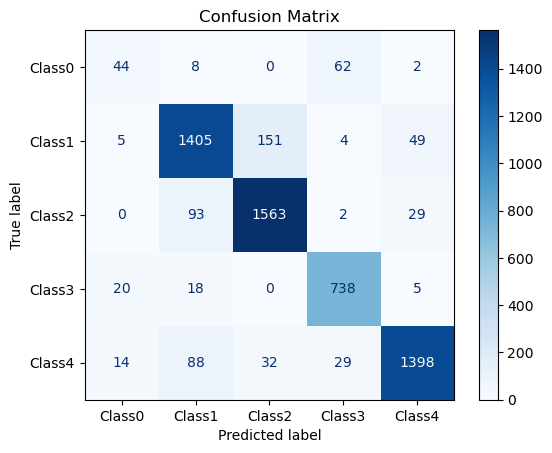

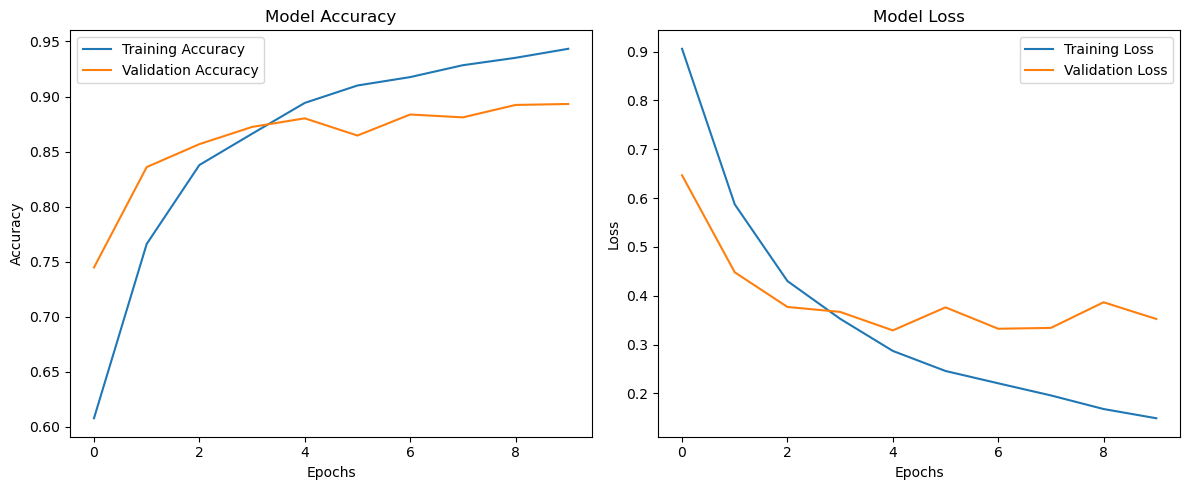

In [25]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the CSV file
labels_df = pd.read_csv(
    r"C:\Users\mousa\OneDrive\Desktop\Subash and Me Star Classifier\USE THIS FOR GALAXY CLASSIFICATION\train_label.csv",
    header=None,
    names=["image_name", "class"]
)

# Append .jpg extension to the image names
labels_df["image_name"] = labels_df["image_name"].astype(str) + ".jpg"

# Step 2: Map Class Names to Folder Names
class_to_folder_map = {
    "Class0": "Cigar-shaped smooth",
    "Class1": "In between smooth",
    "Class2": "completely round smooth",
    "Class3": "edge-on",
    "Class4": "spiral"
}

# Map the folder paths based on the class
image_base_folder = r"C:\Users\mousa\OneDrive\Desktop\Subash and Me Star Classifier\USE THIS FOR GALAXY CLASSIFICATION\Train_images\Train_images"
labels_df["folder_name"] = labels_df["class"].map(class_to_folder_map)
labels_df["image_path"] = labels_df.apply(lambda x: os.path.join(image_base_folder, x["folder_name"], x["image_name"]), axis=1)

# Step 3: Verify paths exist and filter
labels_df = labels_df[labels_df["image_path"].apply(os.path.exists)].reset_index(drop=True)

# Check if labels_df is empty after filtering
if labels_df.empty:
    print("No valid image paths found. Please check your directory and CSV file.")
else:
    print(f"Number of valid image paths: {len(labels_df)}")

    # Step 4: Train-Test-Validation Split
    train_data, test_data = train_test_split(labels_df, test_size=0.2, stratify=labels_df["class"], random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.05, stratify=train_data["class"], random_state=42)

    # Step 5: Image Data Generators
    datagen = ImageDataGenerator(rescale=1./255)

    train_gen = datagen.flow_from_dataframe(
        train_data,
        x_col="image_path",
        y_col="class",
        target_size=(128, 128),
        batch_size=32,
        class_mode="categorical"
    )

    val_gen = datagen.flow_from_dataframe(
        val_data,
        x_col="image_path",
        y_col="class",
        target_size=(128, 128),
        batch_size=32,
        class_mode="categorical"
    )

    test_gen = datagen.flow_from_dataframe(
        test_data,
        x_col="image_path",
        y_col="class",
        target_size=(128, 128),
        batch_size=32,
        class_mode="categorical",
        shuffle=False
    )

    # Step 6: CNN Model
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(len(train_gen.class_indices), activation="softmax")
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Step 7: Train the Model
    history = model.fit(
        train_gen,
        epochs=10,
        validation_data=val_gen
    )

    # Step 8: Evaluate and Visualize Results
    loss, accuracy = model.evaluate(test_gen)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Plot confusion matrix
    predictions = model.predict(test_gen)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_gen.classes

    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()
